# Regresión Logística

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, auc,
    classification_report, ConfusionMatrixDisplay
)

## 1. Carga de datos limpios

In [15]:
df = pd.read_csv('mexico_wbes_clean.csv')

## 2. Definición de variables

**Pregunta:** ¿Se puede clasificar si una empresa es exitosa según sus características?

- **Variable dependiente (Y):** `successful` = 1 si ventas > media nacional, 0 en caso contrario.
- **Variables independientes (X):** `employees`, `age`, `training`, `exporter`, `financing`, `competition`.

In [10]:
FEATURES = ['employees', 'age', 'training', 'exporter', 'financing', 'competition']
TARGET   = 'successful'

X = df[FEATURES].values
y = df[TARGET].values

print('Variables independientes:', FEATURES)
print(f'Variable dependiente: {TARGET} (binaria 0/1)')

Variables independientes: ['employees', 'age', 'training', 'exporter', 'financing', 'competition']
Variable dependiente: successful (binaria 0/1)


## 3. División y escalado

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

scaler    = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

print(f'Entrenamiento: {len(X_train)} muestras')
print(f'Prueba:        {len(X_test)} muestras')

Entrenamiento: 1020 muestras
Prueba:        255 muestras


## 4. Entrenamiento del modelo

In [12]:
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_s, y_train)

y_pred = model.predict(X_test_s)
y_prob = model.predict_proba(X_test_s)[:, 1]

acc     = accuracy_score(y_test, y_pred)
cm      = confusion_matrix(y_test, y_pred)
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

print('=== Métricas del modelo ===')
print(f'  Accuracy : {acc:.4f}  ({acc*100:.1f}%)')
print(f'  AUC-ROC  : {roc_auc:.4f}')
print()
print('=== Reporte de clasificación ===')
print(classification_report(y_test, y_pred, target_names=['No exitosa', 'Exitosa']))

=== Métricas del modelo ===
  Accuracy : 0.9176  (91.8%)
  AUC-ROC  : 0.9757

=== Reporte de clasificación ===
              precision    recall  f1-score   support

  No exitosa       0.93      0.95      0.94       178
     Exitosa       0.88      0.84      0.86        77

    accuracy                           0.92       255
   macro avg       0.91      0.90      0.90       255
weighted avg       0.92      0.92      0.92       255



## 5. Coeficientes y odds-ratios

In [13]:
coef_df = pd.DataFrame({
    'Variable'   : FEATURES,
    'Coeficiente': model.coef_[0],
    'Odds-Ratio' : np.exp(model.coef_[0])
}).sort_values('Coeficiente', ascending=False)

print(coef_df.to_string(index=False))

   Variable  Coeficiente  Odds-Ratio
  employees     3.331803   27.988747
        age     0.428555    1.535037
   training     0.197737    1.218642
  financing    -0.063383    0.938584
competition    -0.125777    0.881812
   exporter    -0.363617    0.695157


## 6. Gráficas

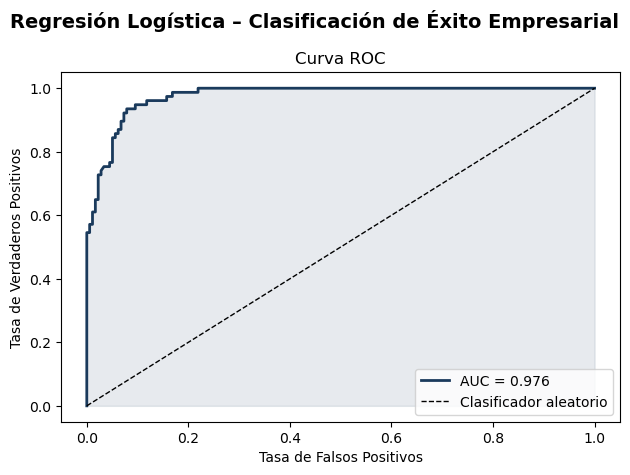

In [14]:
fig, axes = plt.subplots()
fig.suptitle('Regresión Logística – Clasificación de Éxito Empresarial',
             fontsize=14, fontweight='bold')


# --- Curva ROC ---
ax = axes
ax.plot(fpr, tpr, color='#1a3a5c', lw=2, label=f'AUC = {roc_auc:.3f}')
ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Clasificador aleatorio')
ax.fill_between(fpr, tpr, alpha=0.10, color='#1a3a5c')
ax.set_xlabel('Tasa de Falsos Positivos')
ax.set_ylabel('Tasa de Verdaderos Positivos')
ax.set_title('Curva ROC')
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

## 7. Interpretación de resultados

**Accuracy = 91.8%** y **AUC-ROC = 0.976** — el modelo clasifica con alta precisión qué empresas serán exitosas.

**Patrones que predicen el éxito empresarial:**

| Variable | Odds-Ratio | Interpretación |
|---|---|---|
| Empleados | 27.99 | El factor dominante. Una empresa más grande tiene 28× más probabilidad de éxito |
| Antigüedad | 1.54 | Las empresas establecidas tienen ventaja competitiva acumulada |
| Capacitación | 1.22 | Invertir en capital humano mejora moderadamente las probabilidades |
| Exportadora | 0.69 | Ser exportadora no garantiza éxito en ventas totales (muchas venden poco en el mercado local) |
| Financiamiento | 0.94 | Efecto neutro una vez controlado por el tamaño |

**Conclusión:** El tamaño (número de empleados) y la madurez de la empresa son los predictores más fuertes del éxito. La capacitación ofrece una ventaja adicional. Un responsable de políticas debería priorizar programas que faciliten el crecimiento del empleo formal.